In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score


%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

In [2]:
def load_features(files):
    df = pd.read_csv('../dataset/train.csv', index_col=0, usecols=['id', 'target'])
    for file in files:
        df = df.merge(pd.read_csv(file, index_col=0), how='outer', left_index=True, right_index=True)
    return df

In [3]:
full_model = load_features(['../features/features_basicas_texto.csv', '../features/features_basicas_keyword.csv'])

model = full_model[full_model['target'].notnull()]
labels = model['target']
model = model.drop('target', axis=1)

model

,word_count,unique_words_count,word_count_above_mean,unique_words_count_above_mean,char_count,char_count_above_mean,avg_word_length,subjectivity,polarity,neg,neu,pos,has_keyword,keyword_count,keyword_mean,encoded_keyword
id,,,,,,,,,,,,,,,,
1,7,7,0,0,38,0,5.428571,0.000000,0.2732,0,0,1,0,87,0.391892,0.660000
4,7,7,0,0,31,0,4.428571,0.400000,-0.3400,1,0,0,0,87,0.391892,0.702128
5,11,9,1,0,78,1,7.090909,0.400000,0.0000,0,1,0,0,87,0.391892,0.702128
6,8,8,0,0,53,1,6.625000,0.000000,0.0000,0,1,0,0,87,0.391892,0.702128
7,10,10,1,1,47,0,4.700000,0.000000,0.0000,0,1,0,0,87,0.391892,0.652174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10869,9,9,0,0,46,0,5.111111,1.000000,-0.4939,1,0,0,0,87,0.391892,0.652174
10870,9,9,0,0,56,1,6.222222,0.400000,-0.5423,1,0,0,0,87,0.391892,0.652174
10871,6,6,0,0,27,0,4.500000,0.000000,0.0000,0,1,0,0,87,0.391892,0.652174


In [4]:
full_model

,target,word_count,unique_words_count,word_count_above_mean,unique_words_count_above_mean,char_count,char_count_above_mean,avg_word_length,subjectivity,polarity,neg,neu,pos,has_keyword,keyword_count,keyword_mean,encoded_keyword
id,,,,,,,,,,,,,,,,,
0,NaN,4,4,0,0,24,0,6.000000,1.000000,-0.7003,1,0,0,0,87,0.391892,0.688525
1,1.0,7,7,0,0,38,0,5.428571,0.000000,0.2732,0,0,1,0,87,0.391892,0.660000
2,NaN,7,7,0,0,46,0,6.571429,0.550000,0.4404,0,0,1,0,87,0.391892,0.688525
3,NaN,10,10,1,1,52,1,5.200000,0.000000,-0.6159,1,0,0,0,87,0.391892,0.688525
4,1.0,7,7,0,0,31,0,4.428571,0.400000,-0.3400,1,0,0,0,87,0.391892,0.702128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,1.0,6,6,0,0,27,0,4.500000,0.000000,0.0000,0,1,0,0,87,0.391892,0.652174
10872,1.0,14,13,1,1,100,1,7.142857,0.583333,-0.7845,1,0,0,0,87,0.391892,0.652174
10873,1.0,10,9,1,0,49,0,4.900000,0.900000,0.0000,0,1,0,0,87,0.391892,0.666667


# Feature Importance

In [5]:
def feature_importance(model, classifier):
    importances = classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
    indexes = np.argsort(importances)[::-1]
    print("Feature ranking:")
    for f in range(model.shape[1]):
        print(f"{f + 1}. feature {indexes[f]}: {model.columns[f]} ({importances[indexes[f]]})")
    print()
    plt.figure(figsize=(24,12))
    plt.title("Features por importancia")
    plt.bar(range(model.shape[1]), importances[indexes], color="r", yerr=std[indexes], align="center")
    plt.xticks(range(model.shape[1]), indexes)
    plt.xlim([-1, model.shape[1]])
    plt.show()

## Con Random Forest

In [6]:
forest = ExtraTreesClassifier(n_estimators=500,
                              random_state=0,
                              class_weight ={1:1})
forest.fit(model, labels.values.ravel())

ExtraTreesClassifier(class_weight={1: 1}, n_estimators=500, random_state=0)

Feature ranking:
1. feature 15: word_count (0.3490627458567364)
2. feature 4: unique_words_count (0.12156591661898976)
3. feature 6: word_count_above_mean (0.11464642564246764)
4. feature 8: unique_words_count_above_mean (0.10834401624738112)
5. feature 7: char_count (0.08944592305570453)
6. feature 1: char_count_above_mean (0.06646432807046598)
7. feature 0: avg_word_length (0.06353472637397228)
8. feature 11: subjectivity (0.01836091145307542)
9. feature 5: polarity (0.014546666708514504)
10. feature 13: neg (0.011462304577402781)
11. feature 14: neu (0.011335640334502127)
12. feature 9: pos (0.008681725203181131)
13. feature 2: has_keyword (0.0075599137077222755)
14. feature 3: keyword_count (0.007149549654100423)
15. feature 10: keyword_mean (0.005789039114074338)
16. feature 12: encoded_keyword (0.0020501673817092665)



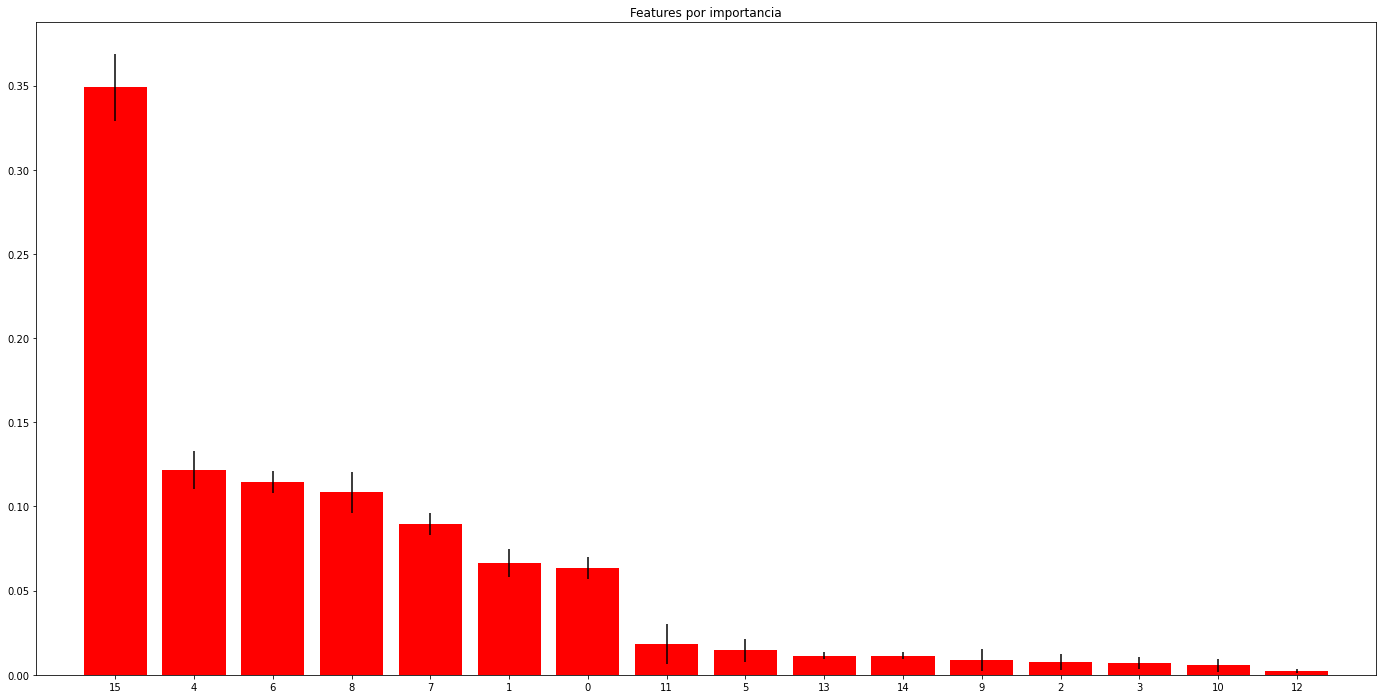

In [7]:
feature_importance(model, forest)

# Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(model, labels,test_size=0.2)
len(X_train),len(X_test),len(y_train),len(y_test)

(6090, 1523, 6090, 1523)

# Probando clasificadores

In [9]:
def try_classifier(classifier):
    classifier.fit(X_train, y_train.values.ravel())
    predictions = classifier.predict(X_test)
    predictions_with_prob = classifier.predict_proba(X_test)[:,1]
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print(f'Verdaderos Negativos: {tn}')
    print(f'Falsos Negativos: {fn}')
    print(f'Verdaderos Positivos: {tp}')
    print(f'Falsos Positivos: {fp}')
    print()
    print(f'accuracy score: {accuracy_score(y_test, predictions)}')
    print(f'roc auc score: {roc_auc_score(y_test,  predictions_with_prob)}')
    print(f'f1 score: {f1_score(y_test,  predictions)}')
    print()
    fig, axs = plt.subplots(3)
    fig.set_size_inches(25,10)
    plt.subplots_adjust(hspace=0.4)
    xgb.plot_importance(xgb_classifier, ax=axs[0], importance_type='weight', title='Feature Importance (weight)')
    xgb.plot_importance(xgb_classifier, ax=axs[1], importance_type='gain', title='Feature Importance (gain)')
    xgb.plot_importance(xgb_classifier, ax=axs[2], importance_type='cover', title='Feature Importance (cover)')
    plt.show()
    return classifier

## XGBoost

In [10]:
# grid search para encontrar hiperparametros

#xgb_classifier = GridSearchCV(
#    xgb.XGBClassifier(),
#    {
#        'max_depth': [1,2,3,4,5,6,7,8,9,10],
#        'n_estimators' :[100,200,500,1000],
#        'learning_rate': [0.0001, 0.001, 0.01, 0.1],
#        'scale_pos_weight': [0.8, 1, 1.2]
#    },
#    scoring="f1",
#    n_jobs=-1,
#    refit=True
#)
#xgb_classifier.best_params_

Verdaderos Negativos: 691
Falsos Negativos: 221
Verdaderos Positivos: 454
Falsos Positivos: 157

accuracy score: 0.7518056467498359
roc auc score: 0.8199082809224318
f1 score: 0.7060653188180405



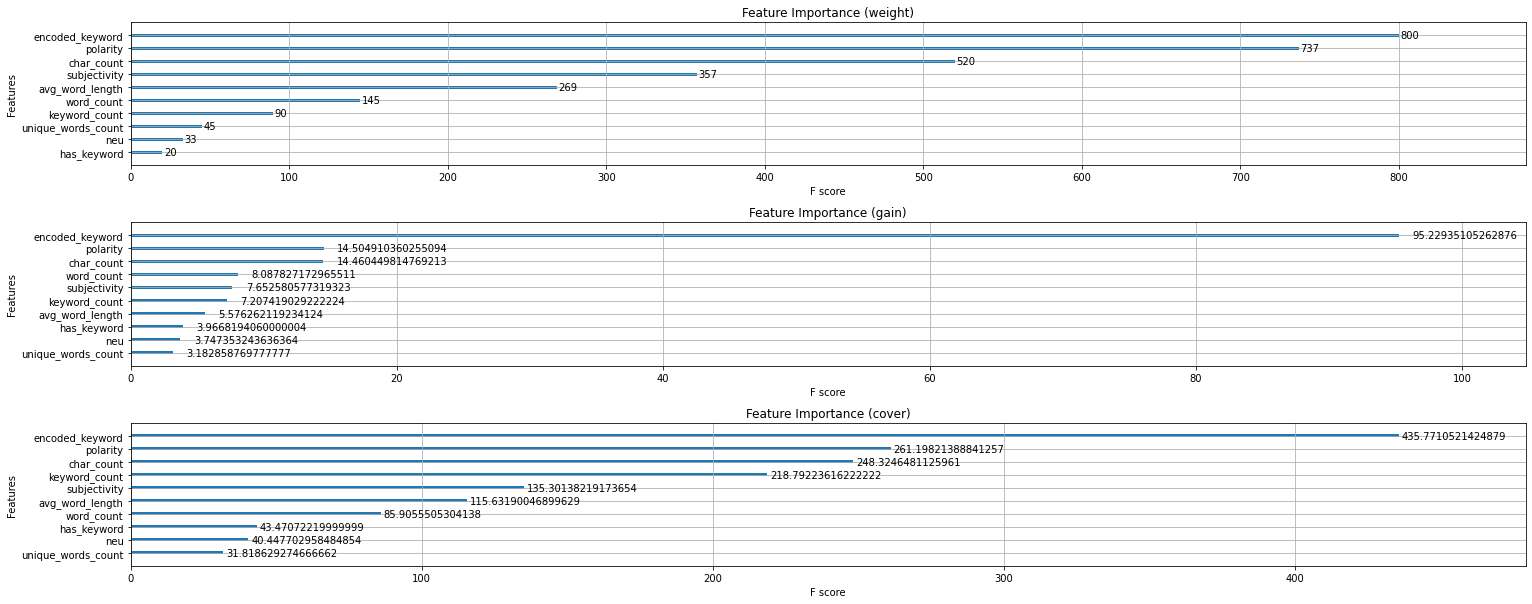

In [11]:
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=5,
    learning_rate=0.01,
    n_estimators=100,
    scale_pos_weight=1.2
)

xgb_classifier = try_classifier(xgb_classifier)


## LightGBM

Verdaderos Negativos: 707
Falsos Negativos: 235
Verdaderos Positivos: 440
Falsos Positivos: 141

accuracy score: 0.7531188443860801
roc auc score: 0.822004716981132
f1 score: 0.7006369426751592



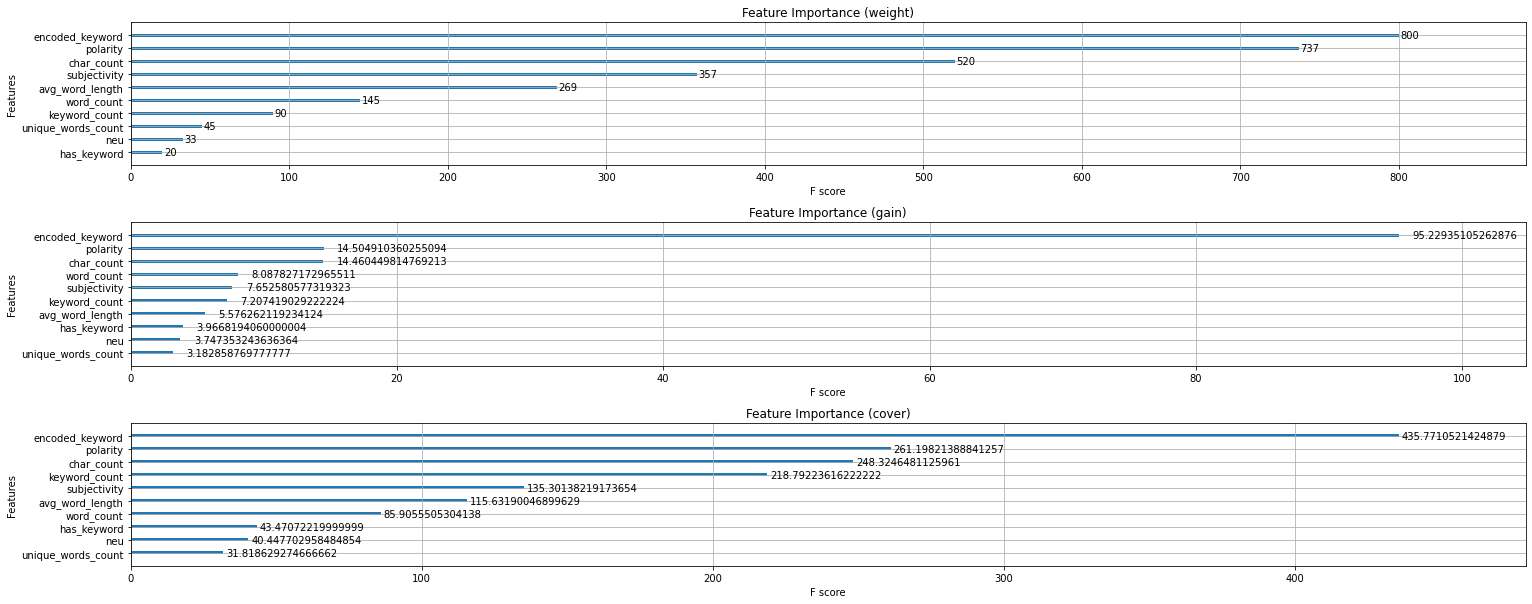

In [12]:
lgbm_classifier = lgb.LGBMClassifier(   
    objective='binary',
    boosting='goss',
    scale_pos_weight=1.2,
    n_estimators=100,
    learning_rate=0.01,
    max_depth=5, 
    num_threads=8,        
)

lgbm_classifier = try_classifier(lgbm_classifier)

## Random Forest

Verdaderos Negativos: 702
Falsos Negativos: 234
Verdaderos Positivos: 441
Falsos Positivos: 146

accuracy score: 0.7504924491135916
roc auc score: 0.8197414395527604
f1 score: 0.6988906497622821



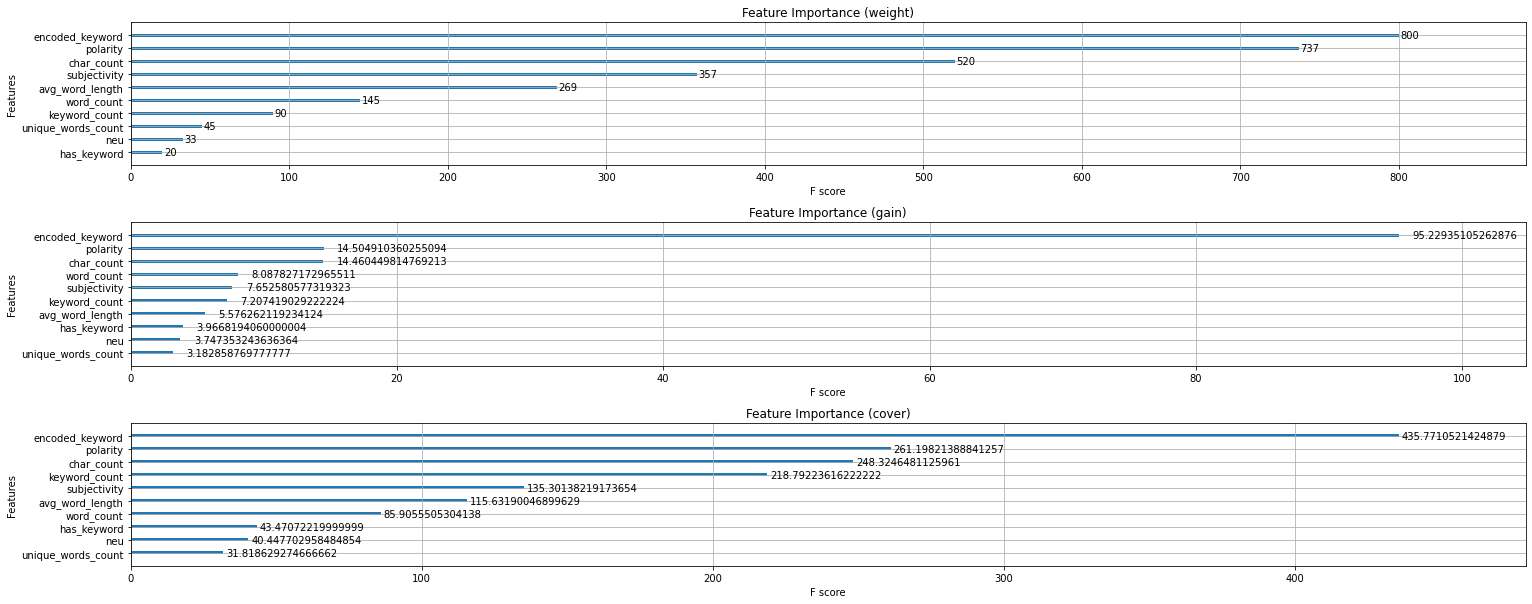

In [13]:
rf_classifier = RandomForestClassifier(
    criterion= 'entropy',
    max_depth= 5,
    n_estimators=100,
    max_features= 'auto',
    class_weight={1:1.2},
    n_jobs=-1
)
rf_classifier = try_classifier(rf_classifier)

## Catboost

Verdaderos Negativos: 672
Falsos Negativos: 211
Verdaderos Positivos: 464
Falsos Positivos: 176

accuracy score: 0.7458962573867367
roc auc score: 0.8182783018867925
f1 score: 0.7057034220532319



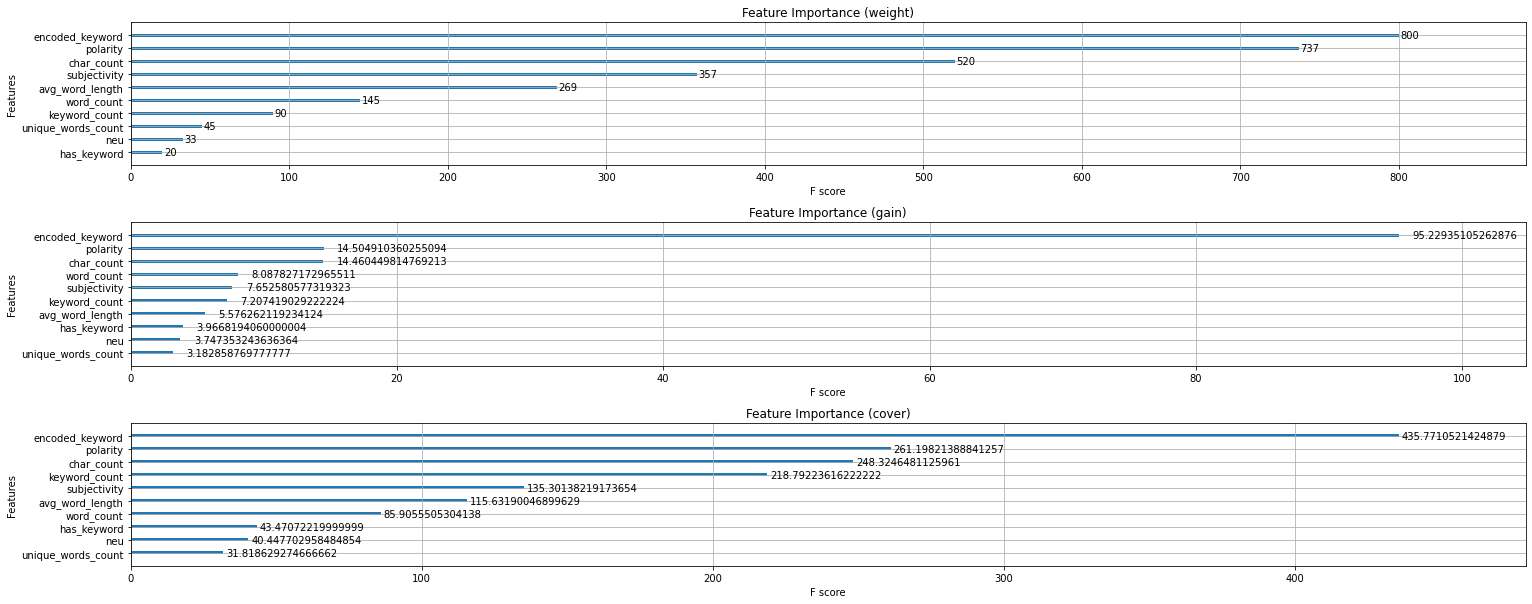

In [14]:
catboost_classifier = CatBoostClassifier(
    class_weights=[1, 1.2],
    logging_level='Silent',
    thread_count=8,
    depth=5,
    n_estimators=100,
    learning_rate=0.01
)

catboost_classifier = try_classifier(catboost_classifier)

# Prepare predictions

In [15]:
test = full_model[full_model['target'].isnull()]
test = test.drop('target', axis=1)

In [16]:
predictions = xgb_classifier.predict(test).astype(int)

In [17]:
result = pd.DataFrame(data={'id': test.index, 'target': predictions})

In [18]:
now = datetime.now(tz=None).strftime('%Y-%m-%dT%H:%M:%S')
result.to_csv(f'../predictions/prediction_{now}.csv', encoding='utf-8', index=False)